In [ ]:
#Install Gymnasium
%pip install -q -U gymnasium swig
%pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00


In [5]:
#Import libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

Episode: 0  Rewards: 100.0
Episode: 0  Rewards: 200.0
Episode: 0  Rewards: 300.0
Episode: 0  Rewards: 400.0
Episode: 0  Rewards: 500.0
Episode: 0  Rewards: 600.0
Episode: 0  Rewards: 700.0
Episode: 0  Rewards: 800.0
Episode: 0  Rewards: 900.0
Episode: 0  Rewards: 1000.0
Episode: 0  Rewards: 1100.0
Episode: 0  Rewards: 1200.0
Episode: 0  Rewards: 1300.0
Episode: 0  Rewards: 1400.0
Episode: 0  Rewards: 1500.0
Episode: 0  Rewards: 1600.0
Episode: 0  Rewards: 1700.0
Episode: 0  Rewards: 1800.0
Episode: 0  Rewards: 1900.0
Episode: 0  Rewards: 2000.0
Episode: 0  Rewards: 2100.0
Episode: 0  Rewards: 2200.0
Episode: 0  Rewards: 2300.0
Episode: 0  Rewards: 2400.0
Episode: 0  Rewards: 2500.0
Episode: 0  Rewards: 2600.0
Episode: 0  Rewards: 2700.0
Episode: 0  Rewards: 2800.0
Episode: 0  Rewards: 2900.0
Episode: 0  Rewards: 3000.0
Episode: 0  Rewards: 3100.0
Episode: 0  Rewards: 3200.0
Episode: 0  Rewards: 3300.0
Episode: 0  Rewards: 3400.0
Episode: 0  Rewards: 3500.0
Episode: 0  Rewards: 3600.0
E

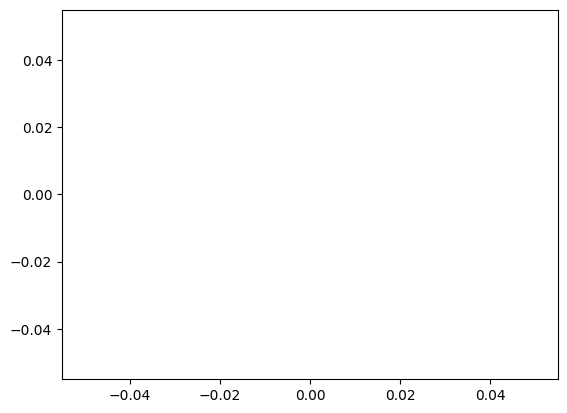

In [7]:
def run(is_training=True, render=False):

    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10) #Valores en los que el agente pierde el juego
    vel_space = np.linspace(-4, 4, 10) #En este va a infinito, pero se pone el valor maximo en el que agente tiene oportunidad
    ang_space = np.linspace(-.2095, .2095, 10) #Valores en los que el agente pierde el juego
    ang_vel_space = np.linspace(-4, 4, 10) #En este va a infinito, pero se pone el valor maximo en el que agente tiene oportunidad

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, env.action_space.n)) # init a 11x11x11x11x2 array
    else:
        f = open('cartpole.pkl', 'rb') # Guarda los valores para que cuando ya no esté entrenando, sepa como moverse
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    # for i in range(episodes):
    while(True):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards < 10000):

            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward
            # Imprimir los valores y episodios en el que va el agente
            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        # Imprimir los valores y episodios en el que va el agente
        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
            break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        i+=1

    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png') # Gráfica que muestra los valores de los entrenamientos del agente
    # El agente no para de entrenar hasta que el promedio de los valores exitosos por episodio sea 1000

# Este if decide si el agente juega o entrena
if __name__ == '__main__':
    #run(is_training=True, render=False)

    run(is_training=False, render=True)